In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)
# reflect the tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
session = Session(engine)
measurement = Base.classes.measurement
station = Base.classes.station

session.query(measurement).all()

 ...]

In [8]:
# Create our session (link) from Python to the DB
query1 = 'SELECT * FROM measurement'
data1 = pd.read_sql(query1, engine)
print(data1)

          id      station        date  prcp  tobs
0          1  USC00519397  2010-01-01  0.08  65.0
1          2  USC00519397  2010-01-02  0.00  63.0
2          3  USC00519397  2010-01-03  0.00  74.0
3          4  USC00519397  2010-01-04  0.00  76.0
4          5  USC00519397  2010-01-06   NaN  73.0
...      ...          ...         ...   ...   ...
19545  19546  USC00516128  2017-08-19  0.09  71.0
19546  19547  USC00516128  2017-08-20   NaN  78.0
19547  19548  USC00516128  2017-08-21  0.56  76.0
19548  19549  USC00516128  2017-08-22  0.50  76.0
19549  19550  USC00516128  2017-08-23  0.45  76.0

[19550 rows x 5 columns]


In [9]:
query2 = 'SELECT * FROM station'
data2 = pd.read_sql(query2, engine)
print(data2)

   id      station                                    name  latitude  \
0   1  USC00519397                    WAIKIKI 717.2, HI US  21.27160   
1   2  USC00513117                    KANEOHE 838.1, HI US  21.42340   
2   3  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130   
3   4  USC00517948                       PEARL CITY, HI US  21.39340   
4   5  USC00518838              UPPER WAHIAWA 874.3, HI US  21.49920   
5   6  USC00519523      WAIMANALO EXPERIMENTAL FARM, HI US  21.33556   
6   7  USC00519281                     WAIHEE 837.5, HI US  21.45167   
7   8  USC00511918       HONOLULU OBSERVATORY 702.2, HI US  21.31520   
8   9  USC00516128            MANOA LYON ARBO 785.2, HI US  21.33310   

   longitude  elevation  
0 -157.81680        3.0  
1 -157.80150       14.6  
2 -157.83740        7.0  
3 -157.97510       11.9  
4 -158.01110      306.6  
5 -157.71139       19.5  
6 -157.84889       32.9  
7 -157.99920        0.9  
8 -157.80250      152.4  


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
query_recent_date = session.query(func.max(measurement.date)).scalar()
query_recent_date

'2017-08-23'

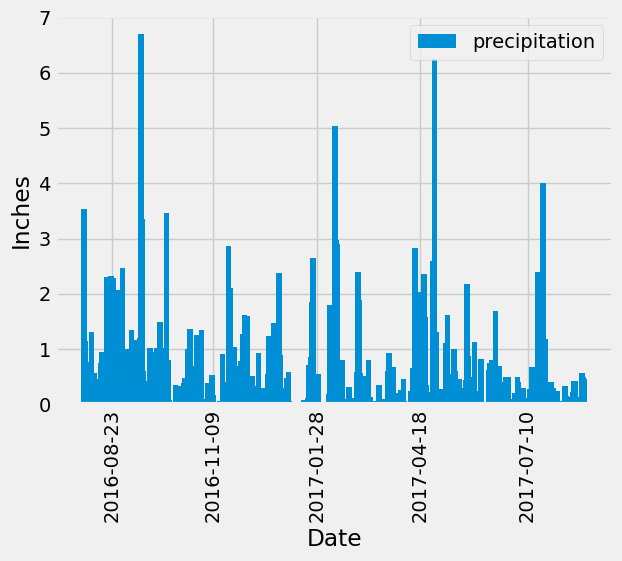

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
query_recent_date = session.query(func.max(measurement.date)).scalar()
# Calculate the date one year from the last date in data set.
timeframe_query = pd.to_datetime(query_recent_date) - pd.DateOffset(months=12)

# Perform a query to retrieve the data and precipitation scores
timeframe_query = timeframe_query.strftime('%Y-%m-$d')
precipitation_info = session.query(measurement.date, measurement.prcp).filter(measurement.date >= timeframe_query).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_visual = pd.DataFrame(precipitation_info, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_visual['Date'] = pd.to_datetime(precipitation_visual['Date'])
precipitation_visual.set_index('Date', inplace=True)
precipitation_visual.sort_index(ascending=False, inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(precipitation_visual.index, precipitation_visual['Precipitation'], width=4.25, label='precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plot_dates = ['2016-08-23', '2016-11-09','2017-01-28','2017-04-18','2017-07-10']
plt.xticks(plot_dates, rotation=90)
plt.legend()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_visual.describe()

,Precipitation
count,2148.000000
mean,0.182896
std,0.467339
min,0.000000
25%,0.000000
50%,0.020000
75%,0.140000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(func.count(station.station)).scalar()
print(stations)

9


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
count_stations = engine.execute("""SELECT station, count(*) as count from measurement group by station order by count DESC;""")
desc_stations = [(row['station'], row['count']) for row in count_stations]
desc_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_temps_query = engine.execute("""SELECT min(tobs) as minm, max(tobs) as maxm, avg(tobs) as avge from measurement where station='USC00519281';""")
active_station_temps = [(row['minm'], row['maxm'], row['avge']) for row in active_station_temps_query]
active_station_temps

[(54.0, 85.0, 71.66378066378067)]

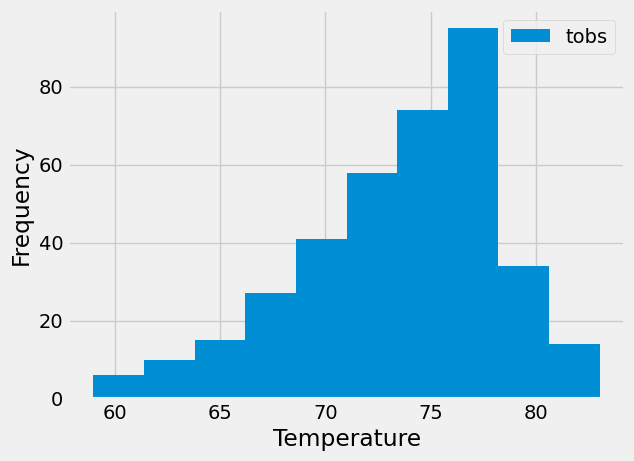

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_hist_query = f"""SELECT tobs from measurement where station = 'USC00519281' and date >= '{timeframe_query}'"""
active_station_hist = pd.read_sql(active_station_hist_query, engine)

plt.hist(active_station_hist['tobs'], label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close Session

In [17]:
# Close Session
session.close()